## SHAP Documentation:
https://github.com/slundberg/shap

In [1]:
import shap, eli5
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

shap.initjs()

### Loading, processing and splitting data for model

In [2]:
X, y = shap.datasets.adult(display=True)
y = np.array([int(label) for label in y])
cat_cols = X.select_dtypes(['category']).columns
X[cat_cols] = X[cat_cols].apply(lambda x: x.cat.codes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
X_test.head(20)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
14160,27.0,4,10.0,0,1,1,4,0,0.0,0.0,38.0,39
27048,45.0,7,9.0,2,4,5,4,0,0.0,0.0,40.0,39
28868,29.0,4,13.0,2,4,0,2,1,0.0,0.0,55.0,39
5667,30.0,4,13.0,4,7,1,4,0,0.0,0.0,40.0,39
7827,29.0,6,10.0,0,3,1,4,1,2202.0,0.0,50.0,39
15382,51.0,4,14.0,2,10,0,4,1,0.0,0.0,47.0,39
4641,58.0,6,9.0,2,4,0,4,1,15024.0,0.0,60.0,39
8943,22.0,4,9.0,4,1,1,3,0,0.0,0.0,40.0,39
216,50.0,4,12.0,0,12,1,4,0,0.0,0.0,40.0,39
5121,50.0,4,9.0,2,3,0,4,1,3103.0,0.0,40.0,39


### Separate dataframe to use labels later

In [3]:
X, y = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(X, y, test_size=0.3, random_state=42)

### Instantiate and fit model

In [4]:
rf = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

## Instantiate SHAP Tree Explainer & Values

In [5]:
%time explainer = shap.TreeExplainer(rf)

CPU times: user 19.6 ms, sys: 7.16 ms, total: 26.7 ms
Wall time: 24.7 ms


In [6]:
%time shap_values = explainer.shap_values(X_test.iloc[:1000,:])

CPU times: user 40.5 s, sys: 357 ms, total: 40.9 s
Wall time: 40.9 s


# Variable / Feature Importance

### Feature importance is calculated by randomizing a features column and holding everything else constant, passing it through your trained model, and seeing how much your accuracy metric drops

In [7]:
def feat_importance(model, df):
    fi = pd.DataFrame({'cols':df.columns, 'importance':model.feature_importances_}
                     ).sort_values('importance', ascending=False)
    return fi.plot('cols', 'importance', 'barh', figsize=(12,7), legend=False)

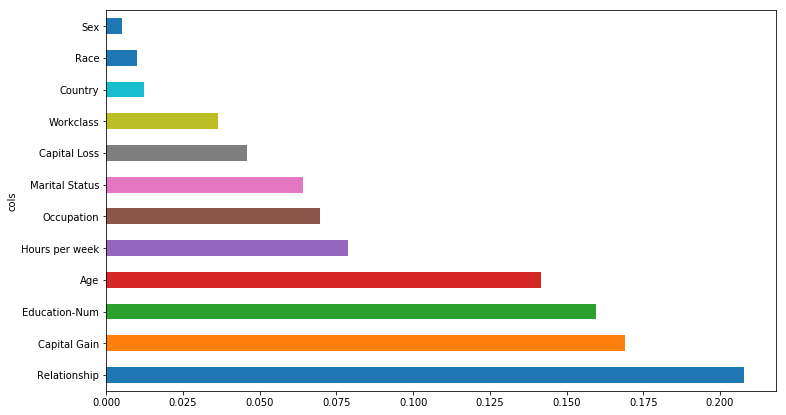

In [8]:
feat_importance(rf, X_train)

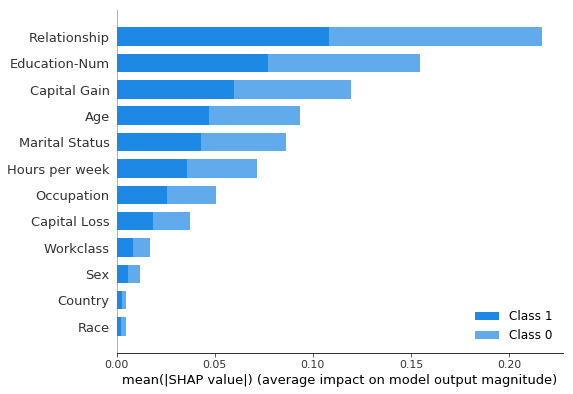

In [10]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Partial Dependence

### Partial Dependence is calculated in a similar manner to feature importance, but instead of randomizing the variable, you hold that variable constant and see how each incremental change in that variable affects predictions

Note: Might need to index values (e.g. shap_values[1]) if slicing dataframe

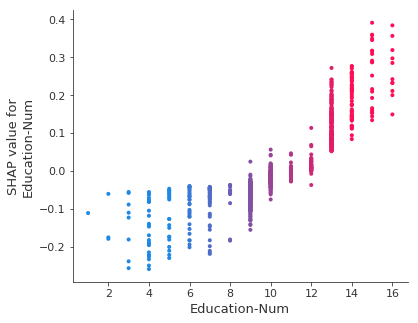

In [11]:
shap.dependence_plot(ind="Education-Num", interaction_index="Education-Num",
                     shap_values=shap_values[1], 
                     features=X_test.iloc[:1000,:],
                     display_features=X_test_disp)

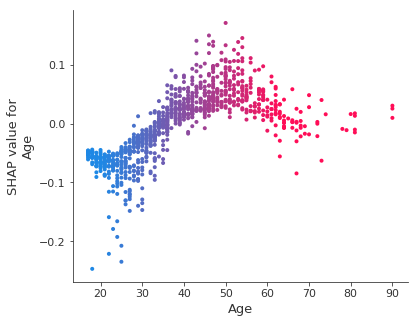

In [12]:
shap.dependence_plot(ind="Age", interaction_index="Age",
                     shap_values=shap_values[1], 
                     features=X_test.iloc[:1000,:],
                     display_features=X_test_disp)

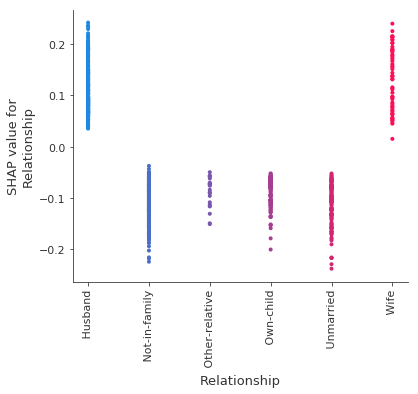

In [13]:
shap.dependence_plot(ind="Relationship", interaction_index="Relationship",
                     shap_values=shap_values[1], 
                     features=X_test.iloc[:1000,:],
                     display_features=X_test_disp)

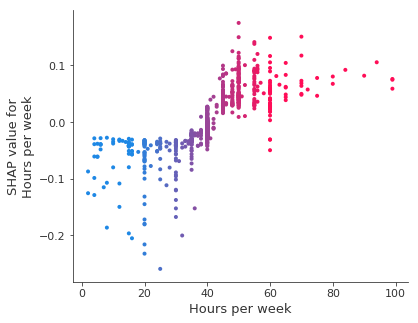

In [14]:
shap.dependence_plot(ind="Hours per week", interaction_index="Hours per week",
                     shap_values=shap_values[1], 
                     features=X_test.iloc[:1000,:],
                     display_features=X_test_disp)

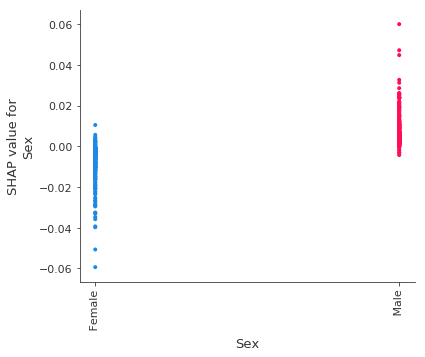

In [15]:
shap.dependence_plot(ind="Sex", interaction_index="Sex",
                     shap_values=shap_values[1], 
                     features=X_test.iloc[:1000,:],
                     display_features=X_test_disp)

In [32]:
from pdpbox import pdp

def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(rf, X_test, X_test.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x10d869ba8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x10d7e3588>})

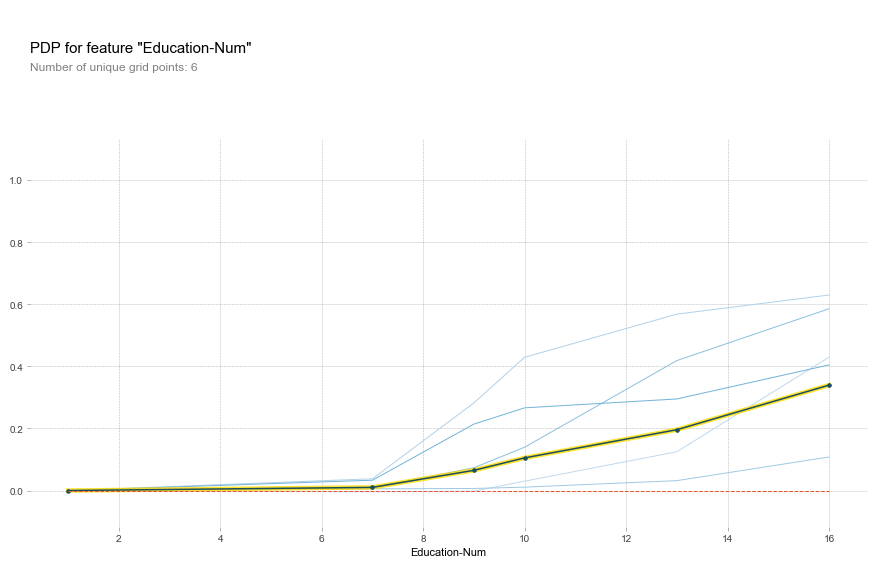

In [33]:
plot_pdp('Education-Num', clusters=5)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x10d5f2a20>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x10d5b04a8>})

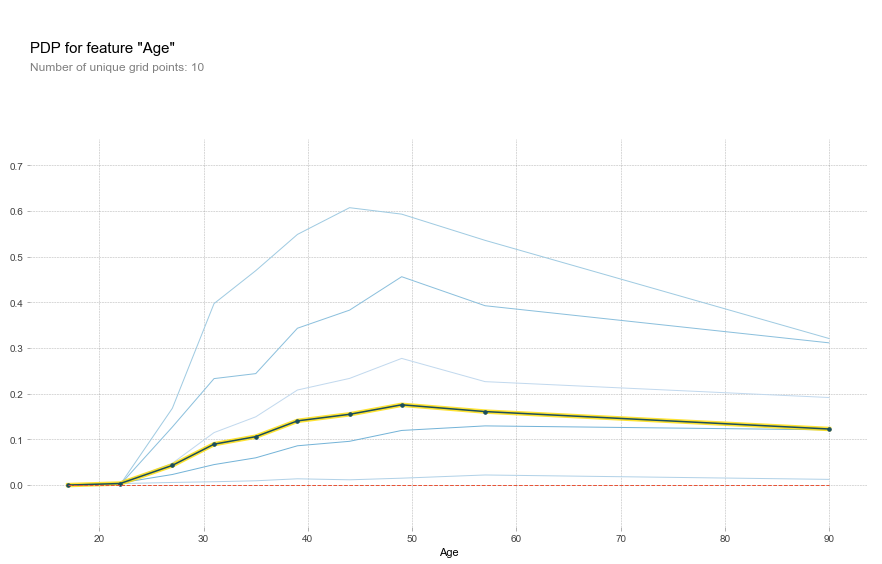

In [35]:
plot_pdp('Age', clusters=5)

# Tree Interpreter (ELI5)

http://blog.datadive.net/interpreting-random-forests/

In [16]:
eli5.show_prediction(rf, X_test.iloc[87], 
                     feature_names=list(X.columns),
                     show_feature_values=True)

# Tree Interpreter for Individual Prediction (SHAP)

In [18]:
shap.force_plot(explainer.expected_value[1], shap_values[1][87], X_test.iloc[87,:])

In [19]:
shap.force_plot(explainer.expected_value[1], shap_values[1][318], X_test.iloc[318,:])

# Tree Interpreter for Range of Predictions (SHAP)

In [20]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:1000,:])

In [21]:
%time shap_values = explainer.shap_values(X_test.iloc[:100,:])

CPU times: user 4.47 s, sys: 71.9 ms, total: 4.54 s
Wall time: 4.7 s


In [22]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:100,:])